In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [2]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import nawrapper as nw
import nawrapper.maptools as maptools

In [3]:
nside = 512
lmax = nside * 3 - 1
B_ell_1 = hp.sphtfunc.gauss_beam(np.deg2rad(0.25), lmax=lmax)
B_ell_2 = hp.sphtfunc.gauss_beam(np.deg2rad(0.45), lmax=lmax)

(0.0, 1.1)

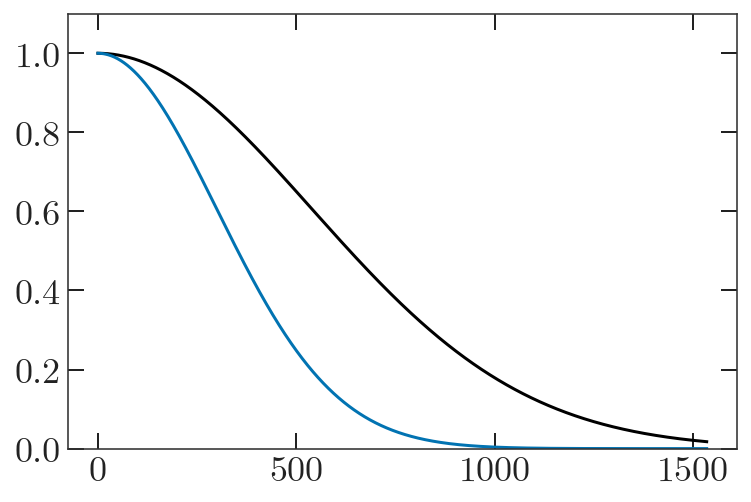

In [4]:
plt.plot(B_ell_1, '-')
plt.plot(B_ell_2, '-')
plt.ylim(0.0, 1.1)

In this notebook we will assume a half-degree beam, and we let `synfast` apply the `pixwin` as well.

We create the *true* power and noise spectra.

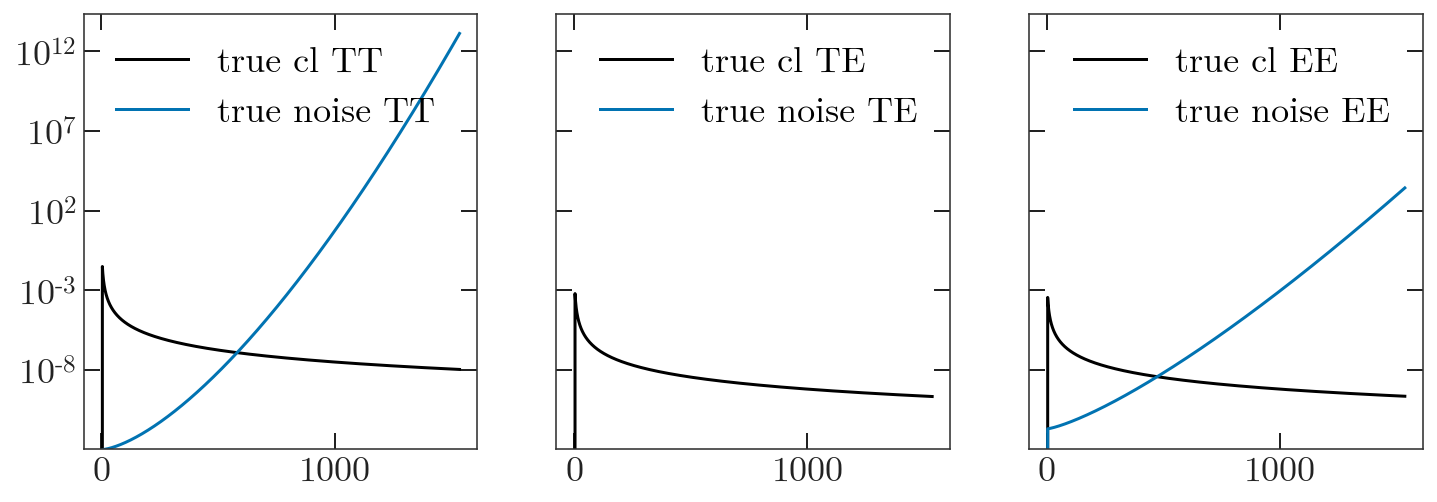

In [26]:
lmin = 4
ells = np.arange(0,lmax+1)

cltt = np.zeros(len(ells))
cltt[lmin:] = 1/ells[lmin:]**2.5 # don't want monopole/dipole

clte = np.zeros(len(ells))
clte[lmin:] = 1/ells[lmin:]**2.5 / 50.0 #* (1 + 0.5 * np.sin(ells/20)[lmin:]) # don't want monopole/dipole

clee = np.zeros(len(ells))
clee[lmin:] = 1/ells[lmin:]**2.4 / 100.0 #* (1 + 0.5 * np.cos(ells/30)[lmin:]) # don't want monopole/dipole

nltt = np.exp( (ells / 100)**1.5 ) / 1e13
nltt[0:lmin] = 0.0

nlte = np.zeros(lmax+1)

nlee = np.exp( (ells / 100)**1.3 ) / 1e11 / 5
nlee[0:lmin] = 0.0

window_func = hp.sphtfunc.pixwin(nside=nside)

fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
ax[0].plot(cltt, '-', label='true cl TT')
ax[0].plot(nltt, '-', label='true noise TT')

ax[1].plot(clte, '-', label='true cl TE')
ax[1].plot(nlte, '-', label='true noise TE')

ax[2].plot(clee, '-', label='true cl EE')
ax[2].plot(nlee, '-', label='true noise EE')

for a in ax: 
    a.set_yscale('log')
    a.legend(frameon=False)

In [27]:
signal_dict = {'TT':cltt, 'TE':clte, 'EE':clee, 
               'BB':np.zeros_like(clee), 'EB':np.zeros_like(clee)}
noise_dict = {'TT':nltt, 'EE':nlee, 'TE':np.zeros_like(clee),
              'BB':np.zeros_like(clee), 'EB':np.zeros_like(clee)}

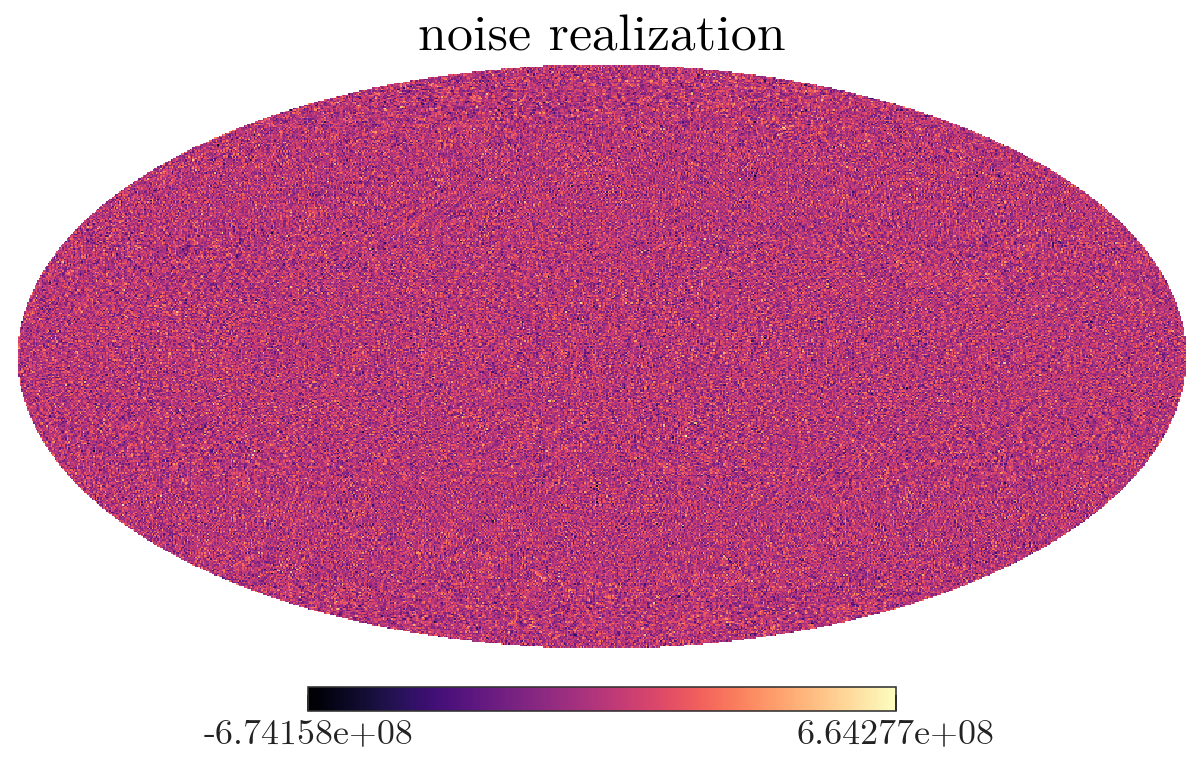

In [28]:
sim = nw.maptools.get_cmb_sim_hp(signal_dict, nside)
noise = nw.maptools.get_cmb_sim_hp(noise_dict, nside)
hp.mollview(noise[0,:], title='noise realization')

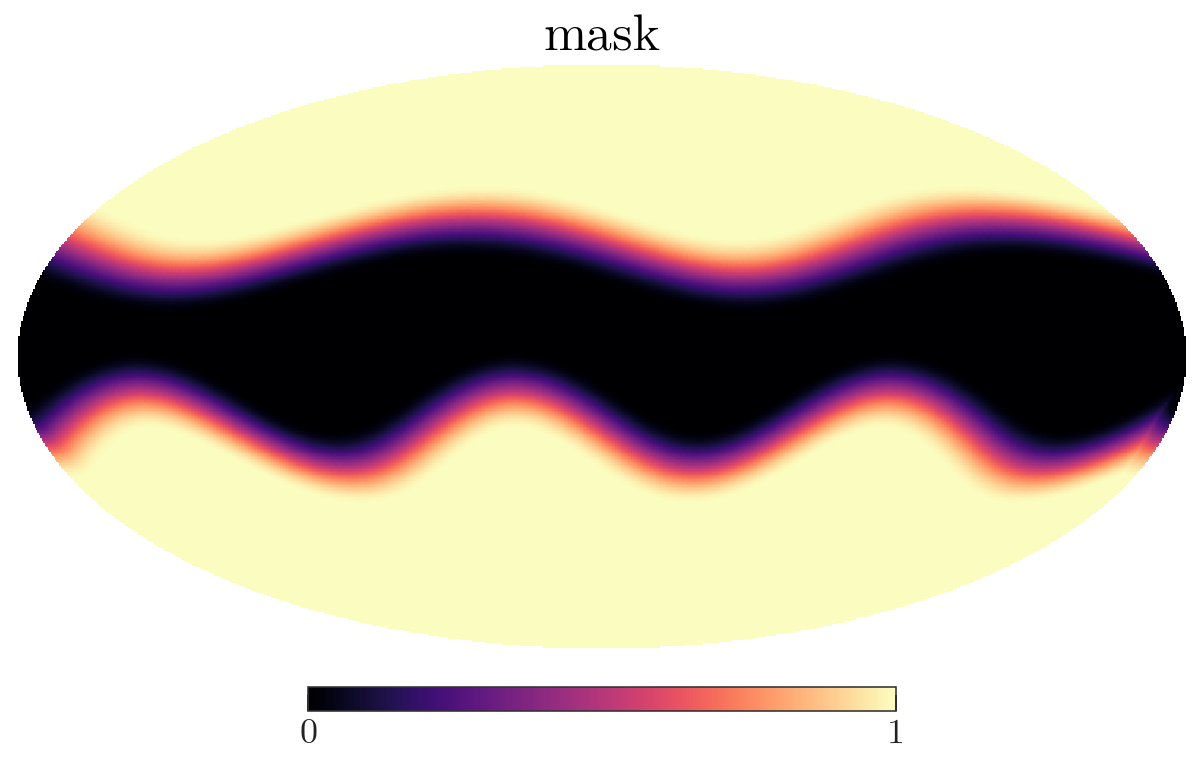

In [29]:
msk = np.zeros(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
msk[np.where((th * (1 + 0.1 * np.sin(ph*3.1+0.1)) > 1.7) | 
             (th * (1 + 0.1 * np.sin(ph*2)) < 1.25) )[0]] = 1.

mask = nmt.mask_apodization(msk, 20.0, apotype='C2')
hp.mollview(mask, title='mask')

In [30]:
def get_maps(noisy=True):
    m = nw.maptools.get_cmb_sim_hp(signal_dict, nside)
    if noisy:
        n1 = nw.maptools.get_cmb_sim_hp(noise_dict, nside)
        n2 = nw.maptools.get_cmb_sim_hp(noise_dict, nside)
        m1_ = hp.smoothing(m + n1, fwhm=np.deg2rad(0.25), verbose=False)
        m2_ = hp.smoothing(m + n2, fwhm=np.deg2rad(0.45), verbose=False)
    else:
        m1_ = hp.smoothing(m, fwhm=np.deg2rad(0.25), verbose=False)
        m2_ = hp.smoothing(m, fwhm=np.deg2rad(0.45), verbose=False)
    
    m1 = nw.namap_hp(maps=m1_, masks=mask,
                  beams=B_ell_1, verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=m2_, masks=mask,
                  beams=B_ell_2, verbose=False, unpixwin=True)
    m1.has_pol = False
    m2.has_pol = False
    return m1, m2

In [31]:
# bins = nw.get_unbinned_bins(lmax)
bins = nmt.NmtBin(nside=nside, nlb=10, lmax=lmax)

In [32]:
m1, m2 = get_maps(noisy=True)
mc = nw.mode_coupling(m1, m2, bins=bins)

In [33]:
test = nw.compute_spectra(m1, m2, mc=mc)

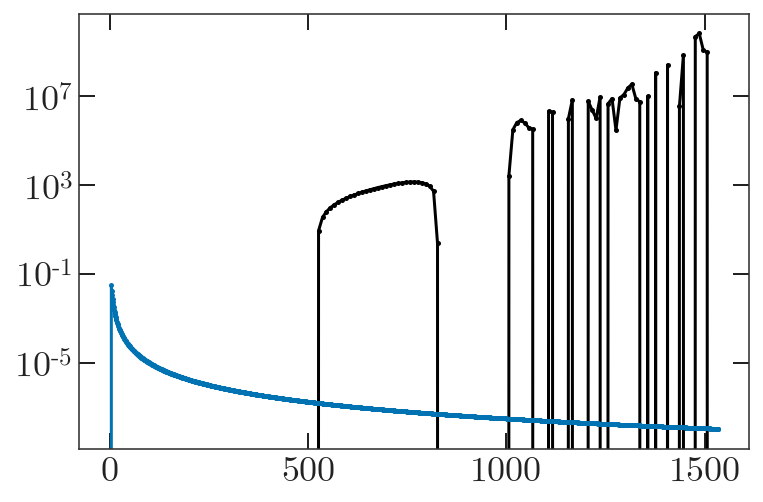

In [36]:
plt.plot(test['ell'], test['TT'])
plt.plot(cltt)
plt.yscale('log')

In [62]:
def get_spec(noisy=True):
    m1, m2 = get_maps(noisy=noisy)
    return nw.compute_spectra(m1, m2, mc=mc, verbose=False)

In [63]:
# m1, m2 = get_maps()
# mc = nw.mode_coupling(m1, m2, bins=nw.get_unbinned_bins(lmax-1, nside=nside))

In [64]:
mc11 = nw.mode_coupling(m1, m1, bins=bins)
mc12 = nw.mode_coupling(m1, m2, bins=bins)
mc22 = nw.mode_coupling(m2, m2, bins=bins)

In [65]:
cov = nw.nacov(m1, m2, mc_11=mc11, mc_12=mc12, mc_22=mc22)
cov.compute()

In [66]:
from tqdm import tqdm
samples = [get_spec(noisy=True) for i in tqdm(range(50), position=0, leave=True)]

TT_means = np.mean([s['TT'] for s in samples], axis=0)
# TE_means = np.mean([s['TE'] for s in samples], axis=0)
# EE_means = np.mean([s['EE'] for s in samples], axis=0)

100%|██████████| 50/50 [12:52<00:00, 15.45s/it]


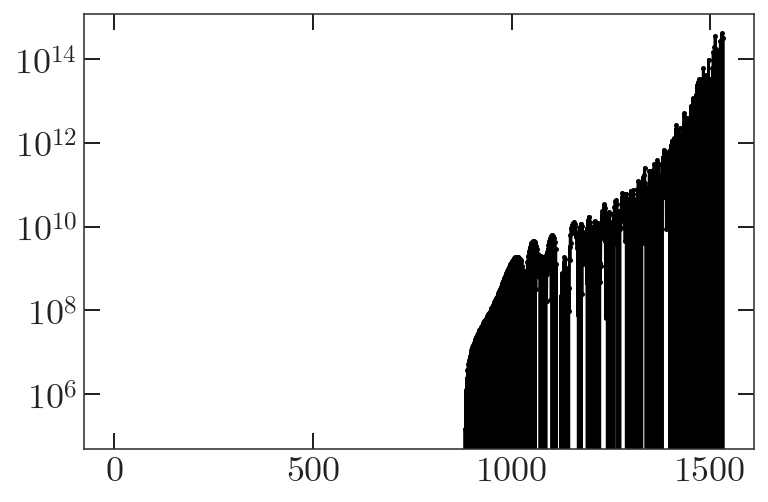

In [74]:
plt.plot(TT_means)
plt.yscale('log')

In [67]:
def ap(x):
    return hp.hstack((np.zeros(2), x))

In [68]:
cov = nw.nacov(m1, m2, mc_11=mc11, mc_12=mc12, mc_22=mc22, 
               signal={'TT': cltt, 'TE':clte, 'EE':clee },
#                noise={'T1T1': nltt, 'T2T2':nltt}, #smoothing_window=1,
#                smoothing_polyorder=0
              )
cov.compute_subcovmat((0,0,0,0))

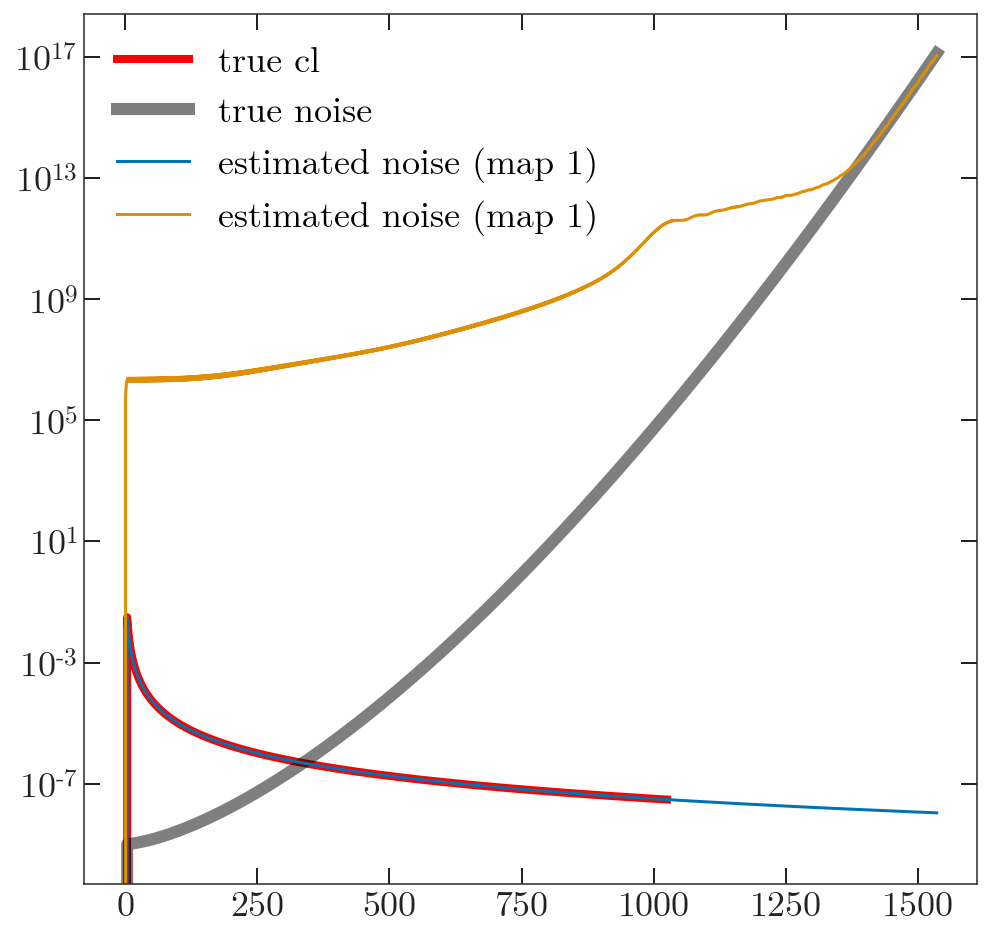

In [69]:
plt.figure(figsize=(8,8))

plt.plot(cltt[:2*nside+2], 'r-', lw=4, label='true cl')
# plt.plot(cov.lb, TT_means, '--', label='map 1 auto')

plt.plot(nltt, '-', label='true noise', alpha=0.5, lw=6)
plt.plot( cov.signal['TT'], '-', label='estimated noise (map 1)')

# plt.plot(cov.Cl22['TT'][:2*nside], '-', label='map 1 auto')
plt.plot( cov.noise['T1T1'], '-', label='estimated noise (map 1)')
# plt.plot( cov.noise['T2T2'], '-', label='estimated noise (map 1)')

plt.legend(frameon=False)
plt.yscale('log')

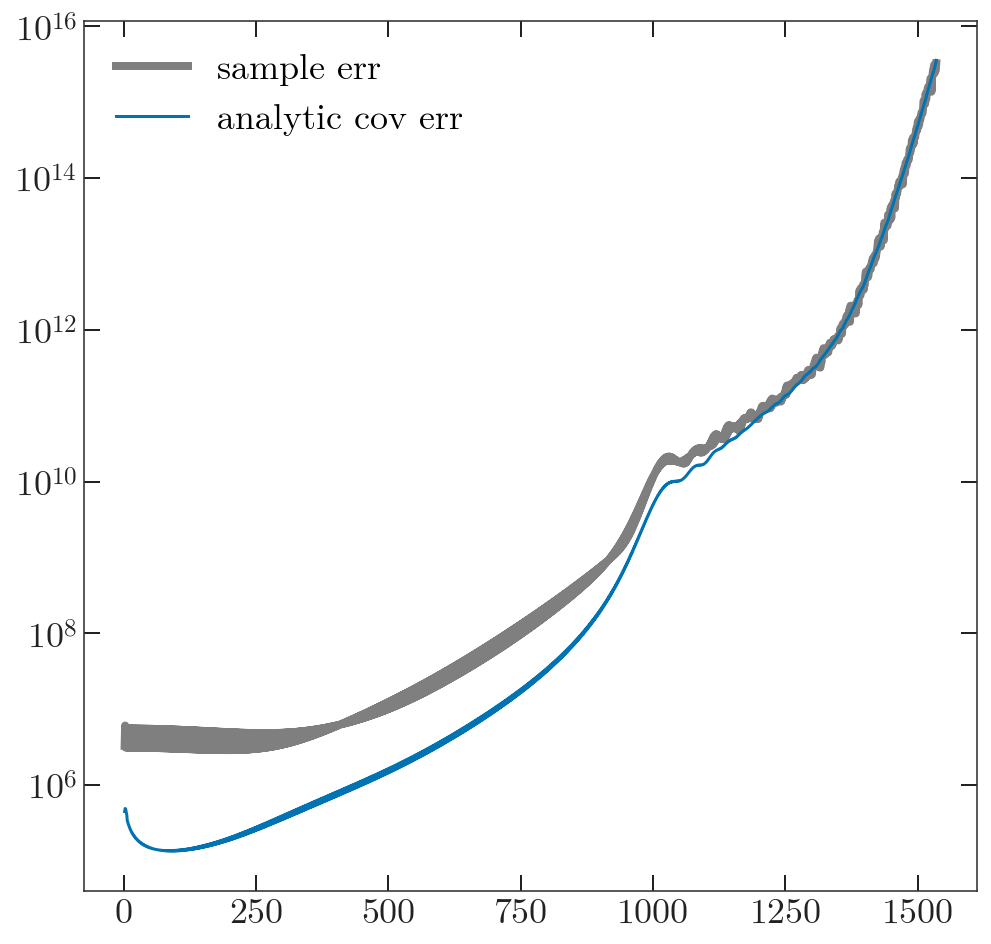

In [70]:
plt.figure(figsize=(8,8))

# plt.plot(cltt[:2*nside+2], 'r-', lw=4, label='true cl')
# plt.plot(cov.lb, TT_means, '--', label='map 1 auto')

# plt.plot(nltt, '-', label='true noise', alpha=0.5, lw=6)

# plt.plot(cov.Cl22['TT'][:2*nside], '-', label='map 1 auto')
# plt.plot( cov.noise['T1T1'], '-', label='estimated noise (map 1)')

plt.plot( cov.lb, np.std([s['TT'] for s in samples], axis=0), '-', lw=4, alpha=0.5, label='sample err')
plt.plot( cov.lb, np.sqrt(np.diag(cov.covmat['TTTT'])), "-", label='analytic cov err')
plt.legend(frameon=False)
plt.yscale('log')

(0.0, 1.2)

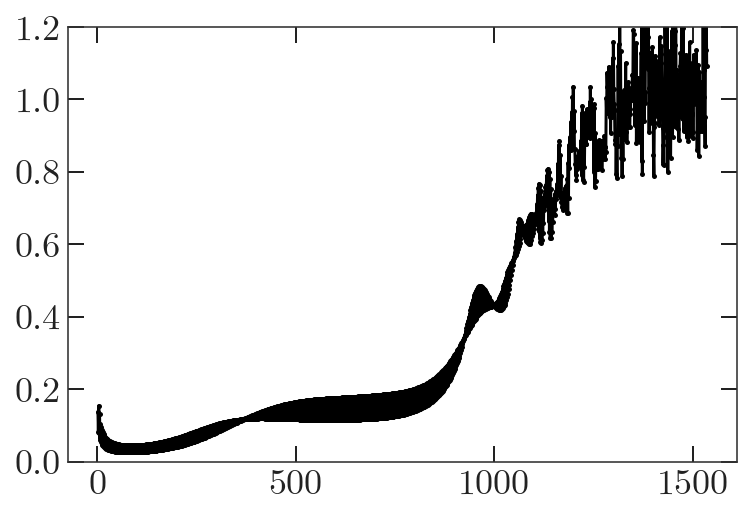

In [71]:
plt.plot(cov.lb, 
         np.sqrt(np.diag(cov.covmat['TTTT'])) / np.std([s['TT'] for s in samples], axis=0) )
# plt.yscale('log')
plt.ylim(0.0,1.2)

KeyError: 'EE'

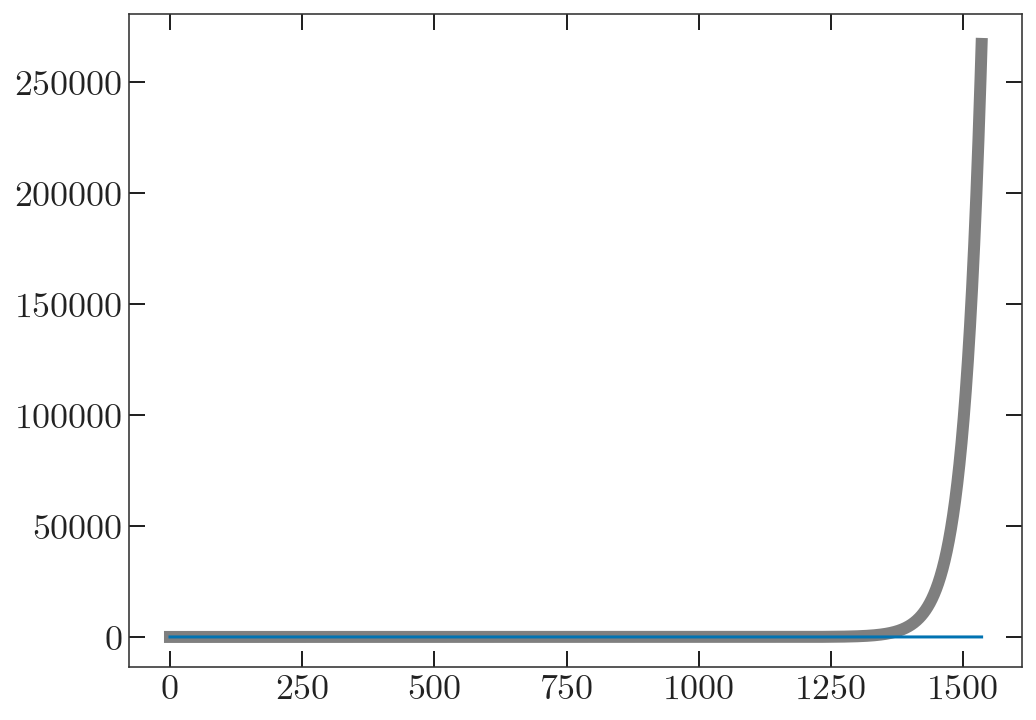

In [72]:
plt.figure(figsize=(8,6))

# plt.plot(cl[:2*nside], '--', label='true cl')
plt.plot(nlee, '-', label='true noise', alpha=0.5, lw=6)
plt.plot(cov.noise['E1E1'], '-', label='estimated noise (map 1)')
plt.plot(cov.lb, np.std([s['EE'] for s in samples], axis=0)[:2*nside], 
         '-', lw=4, alpha=0.5, label='sample err')
plt.plot(cov.lb, np.sqrt(np.diag(cov.covmat['EEEE'])), "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

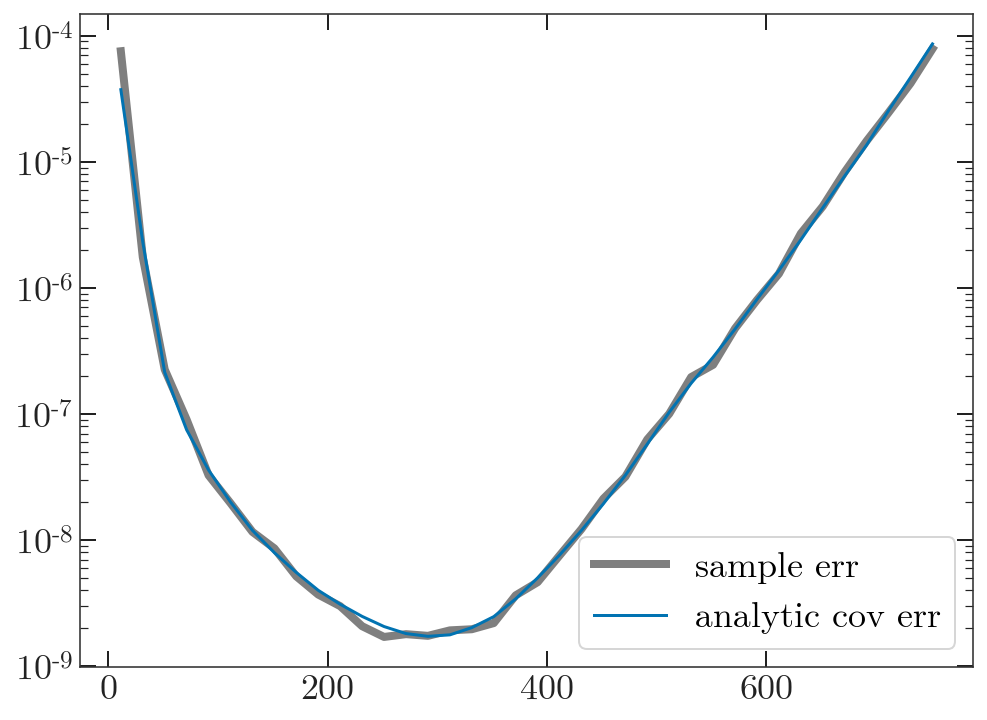

In [42]:
plt.figure(figsize=(8,6))

# plt.plot(cl[:2*nside], '--', label='true cl')
# plt.plot(nl[:2*nside], '-', label='true noise', alpha=0.5, lw=6)
# plt.plot(cov.noise['TE_1'][:2*nside], '-', label='estimated noise (map 1)')
plt.plot(cov.lb, np.std([s['TE'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot(cov.lb, np.sqrt(np.diag(cov.covmat['TETE']))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

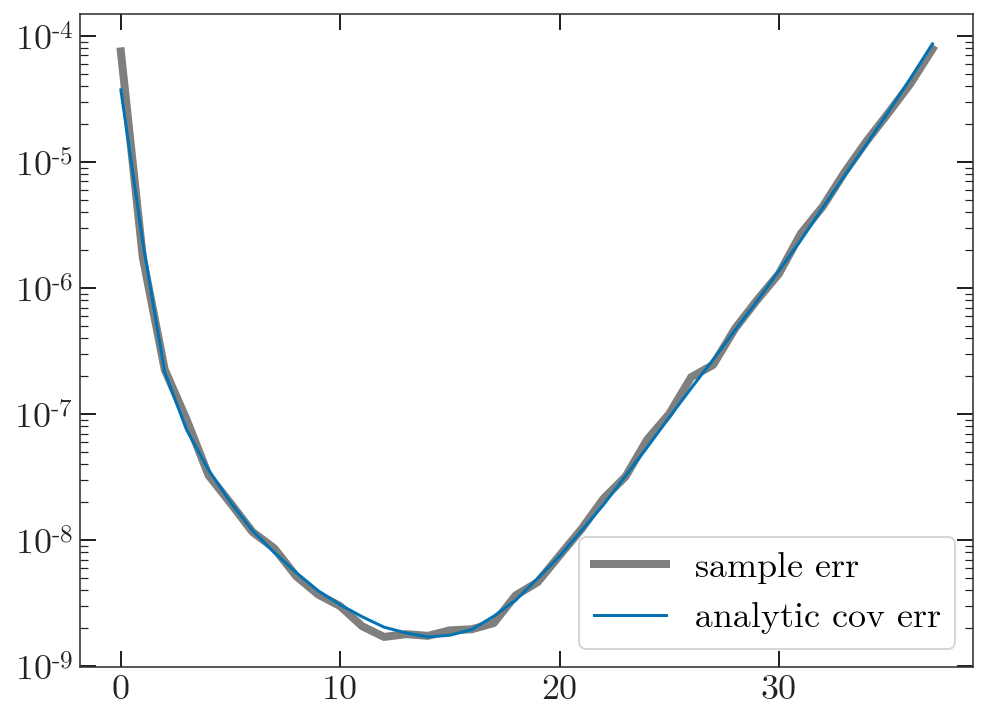

In [43]:
plt.figure(figsize=(8,6))

# plt.plot(cl[:2*nside], '--', label='true cl')
# plt.plot(nl[:2*nside], '-', label='true noise', alpha=0.5, lw=6)
# plt.plot(cov.noise['TE_1'][:2*nside], '-', label='estimated noise (map 1)')
plt.plot( np.std([s['TE'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot( np.sqrt(np.diag(cov.covmat['ETET']))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

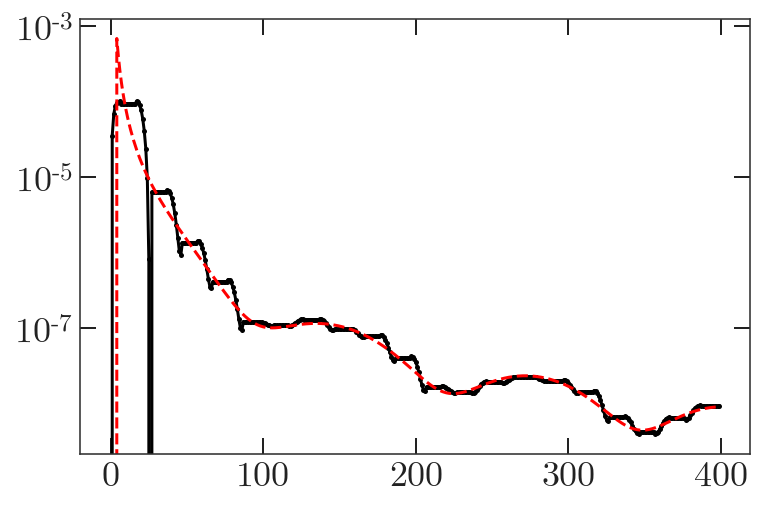

In [35]:
plt.plot(cov.signal['TE'][:400])
# plt.plot(cov.noise['T2T2'][:400])

plt.plot(clte[:400], 'r--')
# plt.plot(nltt[:400], 'r--')

plt.yscale('log')

In [42]:
np

array([[ 1.80225712e-04,  9.72000125e-05,  3.07317083e-04, ...,
         1.19821070e-04,  2.82282400e-04,  2.55538170e-04],
       [ 3.20812934e-06,  4.62656997e-06, -7.82529041e-07, ...,
         4.73088654e-06,  1.10779179e-06,  1.34555019e-06],
       [ 1.49001616e-06,  1.52141794e-06,  1.43157030e-06, ...,
         1.73413936e-06,  1.04714016e-06,  1.43183689e-06],
       ...,
       [ 7.11512718e-10,  7.24987173e-10,  6.96887213e-10, ...,
         7.14048226e-10,  7.00657518e-10,  6.97136164e-10],
       [ 8.49012833e-10,  8.18272366e-10,  8.26343191e-10, ...,
         8.20137701e-10,  8.33321842e-10,  8.48414644e-10],
       [ 8.27620273e-10,  8.42900679e-10,  8.51426025e-10, ...,
         8.20047785e-10,  8.50623950e-10,  8.45022967e-10]])

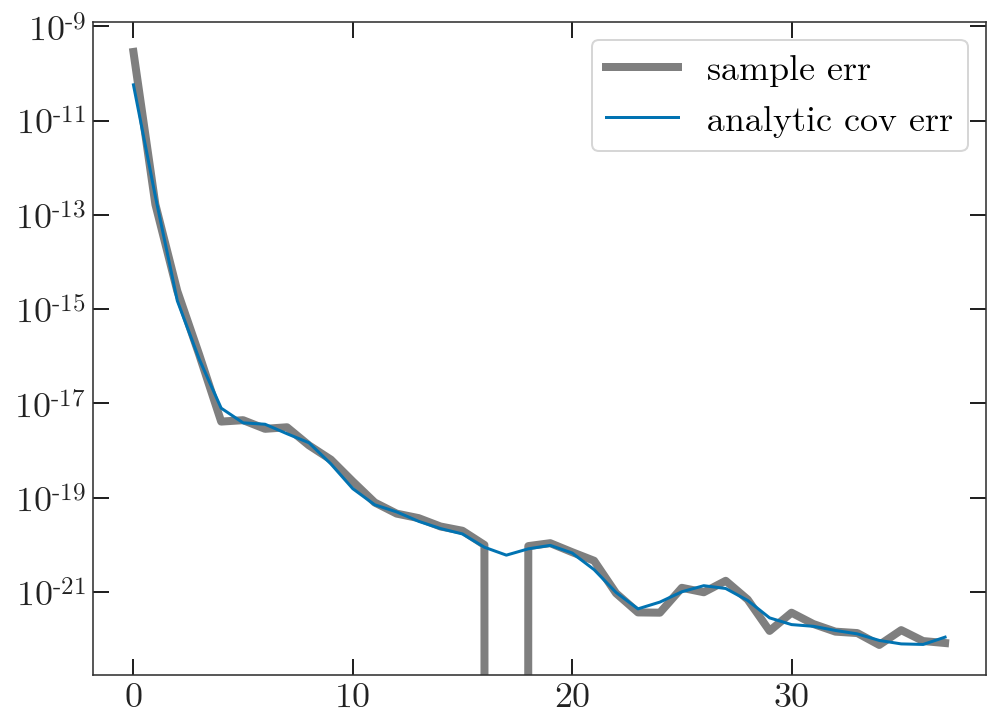

In [45]:
subsamp = np.hstack( ([s['ET'] for s in samples], [s['EE'] for s in samples]) ).T

plt.figure(figsize=(8,6))
plt.plot( np.diag(np.cov(subsamp)[len(cov.lb):,:])[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot( np.diag(cov.covmat['ETEE'])[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

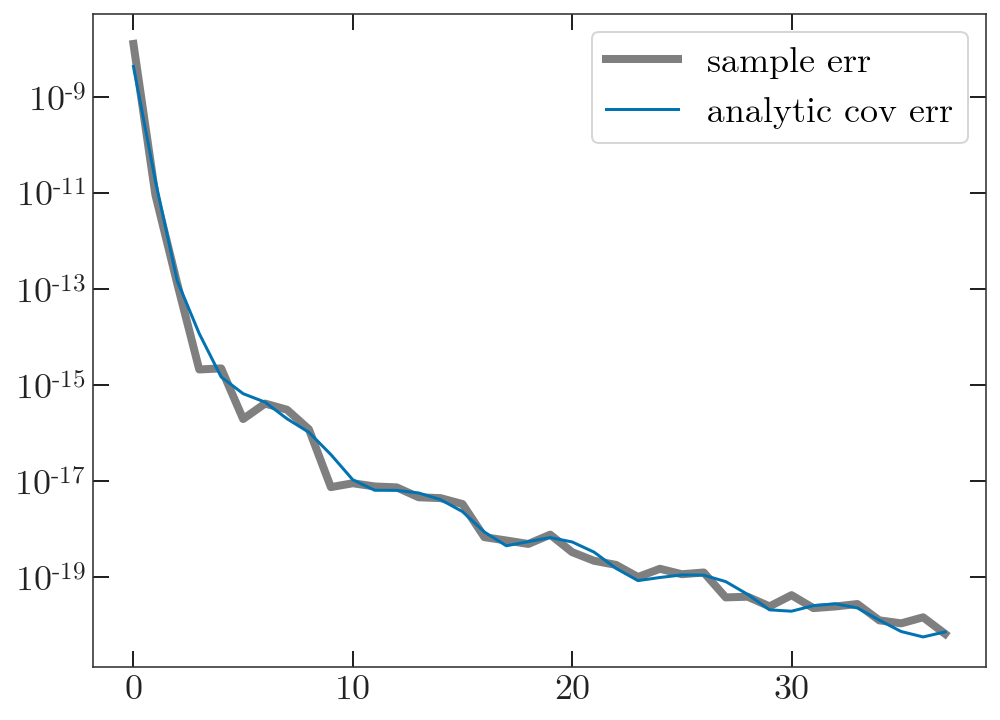

In [47]:
subsamp = np.hstack( ([s['TT'] for s in samples], [s['TE'] for s in samples]) ).T

plt.figure(figsize=(8,6))
plt.plot( np.diag(np.cov(subsamp)[len(cov.lb):,:])[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot( np.diag(cov.covmat['TTTE'])[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

# Different Noise Levels in Each Map

In [25]:
def get_maps_different():
    # apply the pixel window transfer function (pixwin=True)
    m = hp.synfast(B_ell[:lmax]**2 * cl, nside, verbose=False, pixwin=True)
    n1 = hp.synfast(B_ell[:lmax]**2 * nl, nside, verbose=False, pixwin=True)
    n2 = hp.synfast(B_ell[:lmax]**2 * (nl + 1e-5),nside, verbose=False, pixwin=True)
    m1 = nw.namap_hp(maps=(m + n1, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m + n2, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    return m1, m2

def get_spec_different():
    m1, m2 = get_maps_different()
    return nw.compute_spectra(m1, m2, lmax=lmax, verbose=False)['TT']

In [26]:
m1, m2 = get_maps_different()

NameError: name 'B_ell' is not defined

In [ ]:
from tqdm import tqdm
samples = [get_spec_different() for i in tqdm(range(50))]

In [ ]:
m1, m2 = get_maps_different()

mc = nw.mode_coupling(m1, m2, bins=nw.get_unbinned_bins(lmax-1, nside=nside))
cov = nw.nacov(m1, m2, mc_11=mc, mc_12=mc, mc_22=mc)
cov.compute()

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(cl[:2*nside], '--', label='true cl')
plt.plot(nl[:2*nside], '-', label='true noise (map 1)', alpha=0.5, lw=6)
plt.plot(nl[:2*nside] + 1e-5, '-', label='true noise (map 2)', alpha=0.5, lw=6)
plt.plot(cov.noise['TT_1'][:2*nside], '-', label='estimated noise (map 1)')
plt.plot(cov.noise['TT_2'][:2*nside], '-', label='estimated noise (map 2)')
plt.legend()
plt.yscale('log')

plt.figure()
plt.plot( np.std(samples, axis=0)[:2*nside], '-', lw=4, alpha=0.2, label='sample err')
plt.plot( np.sqrt(np.diag(cov.covmat['TTTT']))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')